In [1]:
using LinearAlgebra, Flux, Statistics, Dates, TimeZones, PyCall, Plots
ass = pyimport("astropy.stats");

# Data Importing and Cleaning

<font size="3.5">The data used for the training of the reinforcement learning agent seen below is minute gold futures data from COMEX GCZ2020 between September 29, 2020 at 16:43 to October 6, 2020 at 04:06.</font>

In [2]:
#
# The functions time_change, find_date, data_ret, and line_prediction are functions needed
# and solely use for the importation and cleaning of the financial data I am using.
#


function time_change(T,mins;date_time=false)
    if date_time === false
        date_time = DateTime(T,"dd-u-yyyy HH:MM") + Minute(mins)
        time = Dates.format(date_time, "dd-u-yyyy HH:MM")
    
        return date_time, time
    else
        date_time = T + Minute(mins)
        time = Dates.format(date_time, "dd-u-yyyy HH:MM")
        
        return date_time, time
    end
end



function find_date(elements, value; days=false)
    
    
    left = 1
    right = length(elements)

    first = 1
    last = length(elements)
        
    while left <= right
        middle = (left + right) ÷ 2
        middle_element = elements[middle][5]
        
        if middle != first && middle != last
            left_element = elements[middle-1][5]
            right_element = elements[middle+1][5]

            if middle_element == value
                return middle_element,middle
            end
            if left_element == value
                return left_element,middle-1
            end
            if right_element == value
                return right_element,middle+1
            end
            if middle - left <= 1 && right - middle <= 1
                times_under_consideration = Dict()
                datetime_triple = [(left_element,left_element,middle - 1),
                                   (middle_element,middle_element,middle),
                                   (right_element,right_element,middle + 1)]
                for c in 1:length(datetime_triple)
                    if value > datetime_triple[c][1]
                        times_under_consideration[value - datetime_triple[c][1]] = (datetime_triple[c][2],datetime_triple[c][3])
                    end
                end
                if length(times_under_consideration) > 0
                    to_be_returned = times_under_consideration[minimum(keys(times_under_consideration))] 
                    return to_be_returned
                end
            end
        elseif middle == first || middle == last
            if value <= middle_element
                return middle_element, middle
            end
            if middle_element <= value
                return middle_element, middle
            end
        end
                
        if middle_element < value
            left = middle + 1
        elseif middle_element > value
            right = middle - 1
        end
    end
end



function data_ret(T_date;data_location=data_array,A=0,price_grab=false)
    
    Keys = []
    Data = []
    
    @views begin
    if price_grab === true
        time, index = find_date(data_location[1],T_date)
        push!(Keys,(1,index))
        push!(Data,data_location[1][index])
        return Data[1][9]
    end
    
    for c in 1:length(data_location)
        if c !== 9
            time, index = find_date(data_location[c],T_date)
            push!(Keys,(c,index))
            push!(Data,data_location[c][index])
        else
            time, index = find_date(data_location[c],T_date;days=true)
            push!(Keys,(c,index))
            push!(Data,data_location[c][index])
        end
    end
    
    dP_dt = [Data[c][2] for c in 1:length(Data)]
    dW_dt = [Data[c][1] for c in 1:length(Data)]
    d2P_dt2 = []
    d2W_dt2 = []
    end
        
    if A !== 0
        A += 1
        y_list = [(data_location[1][Keys[1][2]+-c][7]+data_location[1][Keys[1][2]+-c][8])/2 for c in 1:A]
        return dP_dt, dW_dt, d2P_dt2, d2W_dt2, Keys, Data, y_list
    end

    return dP_dt, dW_dt, d2P_dt2, d2W_dt2, Keys, Data
end



function line_prediction(t,dP_dt,dW_dt;d2P_dt2=0,d2W_dt2=0,gamma=1,kappa=0,Price=Price)
    
    predictions_difference = []
    for x in eachindex(dP_dt)
        push!(predictions_difference,((dP_dt[x]*(0-(t/periods[x]))+((0-(t/periods[x]))*(dW_dt[x]-dP_dt[x])*gamma) + Price)))
    end
    
        
    total = []
    
    for c in eachindex(predictions_difference)
        if abs(t-periods[c]) !== 0
            push!(total,(predictions_difference[c]/abs(t-periods[c])))
        else
            push!(total,predictions_difference[c])
        end
    end
    
    average = mean(total)
    
    for c in eachindex(total)
        total[c] = (total[c]/average)*predictions_difference[c]
    end

    prediction = mean(total)
    
    return prediction
end


periods = [1,2,5,10,30,60,120,240,1440]


#
# The function load_files loads the data files I am using, cleans the data, and puts it in an appropriate
# format for use in training.
#

function load_files(s,v)

    data_list = [[], [], [], [], [], [], [], [], []]

    for aa in 1:9
        storage_file = s*"indicator_data_"*string(aa)*".csv"
        
        io = open(storage_file, "r")
        lines = readlines(io)
        split_lines = [split(lines[x],",") for x in 1:length(lines)]

        current_data_times = Set([split_lines[x][5] for x in 1:length(split_lines)])

        if aa != 9
            transform = Dict(1=>x->parse(Float64,x),2=>x->parse(Float64,x),3=>x->parse(Float64,x),4=>x->parse(Int8,x),5=>x->DateTime(x,"dd-u-yyyy HH:MM"),6=>x->parse(Float64,x),7=>x->parse(Float64,x),
                            8=>x->parse(Float64,x),9=>x->parse(Float64,x),10=>x->x,11=>x->x)
        else
            transform = Dict(1=>x->parse(Float64,x),2=>x->parse(Float64,x),3=>x->parse(Float64,x),4=>x->parse(Int8,x),5=>x->DateTime(x,"dd U yyyy"),6=>x->parse(Float64,x),7=>x->parse(Float64,x),
                            8=>x->parse(Float64,x),9=>x->parse(Float64,x),10=>x->x,11=>x->x)
        end

        @views begin
        current_data = [[transform[x](split_lines[c][x]) for x in 1:11] for c in 1:length(split_lines)]
        current_data = unique(current_data)
        end
        close(io)
        #end
        println(length(current_data))

        storage_file = s*"indicator_storage_aggregate_"*string(aa)*".csv"
        io = open(storage_file, "r")
        lines = readlines(io)
        split_lines = [split(lines[x],",") for x in 1:length(lines)]


        @views begin
        aggregate_data = [[transform[x](split_lines[c][x]) for x in 1:11] for c in 1:length(split_lines) if split_lines[c][5] ∉ current_data_times]
        end
        append!(current_data,aggregate_data)
        close(io)

        println(length(current_data))

        data_list[aa] = current_data
    end

    
    volume_file = v

    io = open(volume_file, "r")
    lines = readlines(io)
    split_lines = [split(lines[x],",") for x in 2:length(lines)]
    times = [split_lines[x][1] for x in 1:length(split_lines)]
    volumes = []
    
    try
        volumes = [parse(Int, split_lines[x][6]) for x in 1:length(split_lines)]
    catch ArgumentError
        volumes = [convert(Int,parse(Float64, split_lines[x][6])) for x in 1:length(split_lines)]
    end
    close(io)

    try
        DateTime(times[1],"dd-u-yyyy HH:MM")
    catch
        times = [Dates.format(astimezone(ZonedDateTime(DateTime(replace(times[x],"Z"=>""), "y-m-dTH:M:S"), tz"UTC"), tz"America/Toronto"),"dd-u-yyyy HH:MM") for x in 1:length(times)]
    end

    times = reverse(times)
    volumes = reverse(volumes)
    times_as_datetime = [DateTime(times[x],"dd-u-yyyy HH:MM") for x in 1:length(times)]

    data_list[1] = [data_list[1][c] for c in 1:length(data_list[1]) if data_list[1][c][5] ∈ times_as_datetime]

    @views begin
    for c in 1:length(data_list)
        if c != 9 && length(data_list[c]) > 1
            data_list[c] = sort(data_list[c],by= x -> x[5])
        elseif length(data_list[c]) > 1
            data_list[c] = sort(data_list[c],by= x -> x[5])
        end
    end
    end



    data_datetimes = [data_list[1][c][5] for c in 1:length(data_list[1])]

    vols = Dict()
    data_strings = [Dates.format(data_list[1][c][5], "dd-u-yyyy HH:MM") for c in 1:length(data_list[1])]
    data_set = Set(data_strings)

    @views begin
    for c in 1:length(volumes)
        if times[c] in data_set
            vols[times[c]] = volumes[c]
        end
    end
    end


    println("data_set",length(data_set))

    println(data_list[1][1][5],data_list[1][length(data_list[1])][5])

    vols_tuple = [(times[c],volumes[c]) for c in 1:length(volumes) if times[c] ∈ data_set]
    println("vols: ",length(vols))

    times_as_datetime = nothing
    data_set = nothing
    times = nothing
    volumes = nothing

    looking = 50
    d_d = 25

    All_Prices = Dict()
    All_Predictions = Dict()

    pred_deviation = Dict()
    Price_deviation = Dict()
    difference_deviation = Dict()

    gamma = -15

    println("vols: ",length(vols),"data_list[1]",length(data_list[1]))

    ordered_vols_values = similar(data_list[1],Int64)
    ordered_vols_keys = similar(data_list[1],String)

    for i in 1:length(data_list[1])
        ordered_vols_keys[i] = vols_tuple[i][1]
        ordered_vols_values[i] = vols_tuple[i][2]
    end

    ordered_price_values = similar(data_list[1],Float64)
    ordered_price_keys = similar(data_list[1],String)
    ordered_price_keys_datetime = similar(data_list[1],DateTime)

    ordered_prediction_values = similar(data_list[1],Float64)
    ordered_prediction_keys = similar(data_list[1],String)
    ordered_prediction_keys_datetime = similar(data_list[1],DateTime)

    for i in 1:length(data_list[1])
       @views begin
        T = data_strings[i]
        T_datetime = data_datetimes[i]
        data_T = data_ret(T_datetime;data_location=data_list)
        All_Predictions_time_change = time_change(T_datetime,d_d,date_time=true)[2]

        All_Prices[T] = data_T[6][1][9]
        dW_dt_d = data_T[1]
        dP_dt_d = data_T[2]

        All_Predictions[All_Predictions_time_change] = line_prediction(d_d,dP_dt_d,dW_dt_d;Price=All_Prices[T],gamma=gamma)

        ordered_price_values[i] = data_T[6][1][9]
        ordered_price_keys[i] = T
        ordered_price_keys_datetime[i] = T_datetime

        ordered_prediction_values[i] = All_Predictions[All_Predictions_time_change]
        ordered_prediction_keys[i] = All_Predictions_time_change
        ordered_prediction_keys_datetime[i] = time_change(T_datetime,d_d,date_time=true)[1]
        end
    end

    @views begin
    for c in 1:length(data_list)
        if c === 1 && length(data_list[c]) > 1
            for d in 1:length(data_list[c])
                #transformed = Dates.format(data_list[c][d][5], "dd-u-yyyy HH:MM")
                #data_list_strings_and_datetimes[transformed] = data_list[c][d][5]
                data_list[c][d][5] = Dates.format(data_list[c][d][5], "dd-u-yyyy HH:MM")
            end
        elseif c !== 9 && length(data_list[c]) > 1
            for d in 1:length(data_list[c])
                data_list[c][d][5] = Dates.format(data_list[c][d][5], "dd-u-yyyy HH:MM")
            end
        elseif length(data_list[c]) > 1
            for d in 1:length(data_list[c])
                data_list[c][d][5] = Dates.format(data_list[c][d][5], "dd U yyyy")
            end
        end
    end
    end

    return ordered_vols_values, ordered_vols_keys, ordered_price_values, ordered_price_keys, ordered_prediction_values, ordered_prediction_keys, data_list, ordered_prediction_values
end



loaded_data = load_files("Price_data","Volume_data");



times = Float32[]
days_of_week = Float32[]
for c=1:length(loaded_data[2])
    time = Dates.Time((DateTime(loaded_data[2][c],"dd-u-yyyy HH:MM")))
    time_string = Dates.format(time, "HH:MM")
    week_day = Dates.dayofweek((DateTime(loaded_data[2][c],"dd-u-yyyy HH:MM")))
    push!(days_of_week,week_day)
    
    push!(times,parse(Int32,time_string[1:2])*60 + parse(Int32,time_string[4:5]))
end



#
# williams_ad is an implemtation of the williams accumulation distribution technical indicator
#

function williams_ad(data)
    WAD = zeros(Float32,length(data))
    WAD[1] = data[1][9]
    
    for c=1:length(data)
        if c > 1
            prev_value = WAD[c-1]
            prev_close = data[c-1][9]
            if data[c][9] > prev_close
                ad = data[c][9] - minimum([prev_close, data[c][8]])
            elseif data[c][9] < prev_close
                ad = data[c][9] - maximum([prev_close, data[c][7]])
            else
                ad = 0.
            end
            
            WAD[c] = ad + prev_value
        end
    end
    
    return WAD
end



#
# Compiling the data matrix together from the  data
#


n = length(loaded_data[1])
X = zeros(Float32,11,n)
X[1,:] = loaded_data[3][1:n]
X[2,:] = loaded_data[1][1:n]
X[3,:] = [loaded_data[7][1][1:n][c][1] for c =1:length(loaded_data[7][1][1:n])]
X[4,:] = [loaded_data[7][1][1:n][c][2] for c =1:length(loaded_data[7][1][1:n])]
X[5,:] = williams_ad(loaded_data[7][1][1:n])
difference_WAD = diff(williams_ad(loaded_data[7][1][1:n]))
difference_WAD = vcat(Float32[0.f0], difference_WAD)
X[6,:] = difference_WAD
difference_price = diff(loaded_data[3][1:n])
difference_price = vcat(Float32[0.f0], difference_price)
X[7,:] = difference_price
difference_volume = diff(loaded_data[1][1:n])
difference_volume = vcat(Float32[0.f0], difference_volume)
X[8,:] = difference_volume
X[9,:] = loaded_data[8][1:n];
X[10,:] = times[1:n]
X[11,:] = days_of_week[1:n];

difference_WAD = nothing
difference_price = nothing
difference_volume = nothing




prices = loaded_data[3][1:n]
sde_data = X
scaling_range = 1:85000


#
# MV_standardize is an implementation of multivariate standardization which is done using the biweight
# location and biweight midcovariance matrix instead of the mean and covariance matrix respectively.
# This choice is done due to my experience that in financial data these statistics can offer more
# information when they are used to standardize instead of mean and covariance due to lower sensitivity.
#


function MV_standardize(sde_data,scaling_range)
    SL = transpose(sde_data)

    
    SL_T = transpose(SL)
    SL_S = similar(SL_T)
    μ = [convert(Float32,ass.biweight_location(SL[scaling_range,c])) for c in 1:size(sde_data)[1]]
    Σ = ass.biweight_midcovariance(SL_T[:,scaling_range])
    Σ = [convert(Float32,Σ[c,d]) for c=1:size(Σ)[1], d=1:size(Σ)[2]]

    Σ = ((Σ)^(-1))^(1/2)


    for c in 1:size(sde_data)[2]
        SL_S[:,c] = Σ*(SL_T[:,c] - μ)
    end
    
    return SL_S
end



sde_data = MV_standardize(sde_data,scaling_range,Σ=Σ,μ=μ)
SDE = deepcopy(sde_data)



10000
118430
5000
53223
2000
21877
1000
10915
334
3904
167
1991
84
1072
42
578
0
83
data_set118385
2020-07-27T06:21:002020-11-26T11:00:00
vols: 118385
vols: 118385data_list[1]118385


11×90000 Matrix{Float32}:
 -0.614298   -0.306866  -0.0895664  …  -1.09971    -1.16044   -1.08443
 -0.955186   -0.898524  -0.898109       0.832313   -0.111926  -0.193491
 -0.253459    0.503066   1.03196       -0.253508   -0.460548  -0.36896
  2.2876      1.66966    1.30798       -0.131907   -0.101853  -0.266856
 -2.10481    -2.11333   -2.11156        1.93963     1.92907    1.92256
 -0.0191491  -1.37407    0.336888   …  -0.0983289   0.168835   0.536094
 -0.0734421   0.547043   0.599537      -1.08401     0.519918   0.458255
  0.177579    0.259612   0.157577       1.65432    -1.73603    0.151454
 -0.857587   -1.2148    -1.445          0.292013    0.366199   0.30841
 -0.769535   -0.765095  -0.762582       1.28852     1.25921    1.25473
 -1.01361    -1.00998   -1.00686    …  -0.196495   -0.174816  -0.162342

# Preparing the networks and adjusting training parameters

Below is an LSTM helper network trained on COMEX GCZ2020 data before the data used here to train the reinforcement learner.

In [3]:
#
# Here we create a 6 layer LSTM neural network that will augment the data imputs to the
# reinforcement learner as a further state variable which has been trained on short term
# prediction of price fluctuations. After creation we load the trained weights into the 
# network.
#


m = Chain(LSTM(11, 300), LSTM(300,200), LSTM(200,100), LSTM(100,30), LSTM(30,100), Dense(100, 2))

io = open("m_weights", "r");
a = readline(io)
close(io)

marks = [];


for c=1:length(a)
    if a[c] === '.'
        if c-2 >= 1
            if a[c-2] === '-'
                push!(marks,c-2)
            else
                push!(marks,c-1)
            end
        else
            push!(marks,c-1)
        end
    end
end

W = zeros(Float32,length(marks));

for c=1:length(marks)-1
    W[c] = parse(Float32,a[marks[c]:marks[c+1]-1])
end

i = 0
for a=1:length(Flux.params(m))
    if length(size(Flux.params(m)[a])) > 1
        for c=1:size(Flux.params(m)[a])[1], d=1:size(Flux.params(m)[a])[2]
            i += 1
            Flux.params(m)[a][c,d] = W[i]
        end
    else
        for c=1:length(Flux.params(m)[a])
            i += 1
            Flux.params(m)[a][c] = W[i]
        end
    end
end

seq = [[sde_data[d,c] for d=1:size(sde_data)[1]] for c=scaling_range];

In [94]:
#
# Within this model I have chosen these 5 layer LSTM networks for the state value function and 
# to act as an initial input to the preference function 
#


Preference_network = Chain(
    LSTM(19,190),
    LSTM(190,90),
    LSTM(90,40),
    LSTM(40,50),
    Dense(50,3));
State_value_function = Chain(
    LSTM(19,130),
    LSTM(130,70),
    LSTM(70,35),
    LSTM(35,40),
    Dense(40,1));

In [95]:
#
# This is the full preference function which will be used as part of the policy. In addition
# to the input from the Preference_network, specific attention is paid here to the state inputs
# provided by the 6 layer LSTM price prediction network "m"
#

function Preference_function(s)
    
    # current and previous price predictions of the network m
    current = Float32[s[1],s[2]]
    previous = Float32[s[3],s[4]]
    # history is an exponential moving average of previous preferences to buy and sell
    history = Float32[s[5],s[6]]
    
    # Values used in the calculation of the exponential moving average
    r_1 = 0.f0
    r_2 = 0.f0
    
    
    # Drawing the initial preference input
    Pref = abs.(Preference_network(s))
    
    
    # New values for the exponential moving average are based on the predictions of m 
    # magnified by exponentiation depending on the preference to do something (Pref[3]) 
    # as opposed to nothing
    
    if current[1] - previous[1] > 0
        r_1 += (current[1] - previous[1])^(1.5+15*Pref[3])
    else
        r_2 += (-(current[1] - previous[1]))^(1.5+15*Pref[3])
    end


    if current[2] - previous[2] > 0
        r_1 += ((current[2] - previous[2])/2)^(1.5+15*Pref[3])
        else 
        r_2 += (-((current[2] - previous[2])/2))^(1.5+15*Pref[3])
    end

    
    # Weights of the exponential moving average
    weights = Float32[0.6f0,0.4f0]
    
    # Calculation of new EMA value
    history = weights[1].*history + weights[2].*Float32[r_1,r_2]

    # If there is agreement in the EMA of buying and selling and the current preference to buy and sell
    # then we choose to buy amplified by the preference to do something 
    if history[1] > Pref[1] && history[2] < Pref[2]
        choice = Float32[Pref[1]+Pref[3],0.,0.]
    elseif history[1] < Pref[1] && history[2] > Pref[2]
        choice = Float32[0.,Pref[2]+Pref[3],0.]
    else
        # If there is isn't agreement with current preference and the history we channel the 
        # preference for doing anything into doing nothing as this preference is not valid
        choice = Float32[0.,0.,Pref[1]+Pref[2]+Pref[3]]
    end
    
    
    return choice, history, Pref
end

Preference_function (generic function with 1 method)

In [96]:
# This is the policy function used to choose the action, but currently I am exploring 
# the effects of making it deterministic in the maximum value of the preference function
# (this can be seen by how the output of the preference function is constructed)
# as opposed to using softmax when making the action choice

function Policy_choice(s)
    preference, history, P = Preference_function(s)
    return findall(x->x == maximum(preference),preference)[1], history, P
end

Policy_choice (generic function with 1 method)

In [97]:
# This gives the softmax probabilities which are used later during learning
function π_(a,s)
    M = Flux.softmax(Preference_network(s))
    return M[a]
end

π_ (generic function with 1 method)

In [271]:
# Selecting data used to train, each data point is on the minute timescale

_begin_ = 62000
_end_ = 67000

D = prices[_begin_:_end_];
D = [convert(Float32,c) for c in D];

value_history = []

Any[]

In [106]:
#
# These are the parameters of the actor-critic with eligibility traces (continuing) algorithm
#

# Step size of the gradient descent of the state value function network and preference function network
# respectively
η_w = 0.00018
η_θ = 0.00009

# Weight of the new componenet of the expoenential moving average of the reward
η_R̂ = 0.025

# Weights on the Eligibility traces
λ_w = 0.11
λ_θ = 0.18

0.18

# Training 

<font size="3.5"> In this section I have implemented the continuous verion of actor-critic with eligibility traces. I have previously implemented and used REINFORCE, REINFORCE with baseline, and Q-learning for episodic tasks such as mazes and the multi-armed bandit. I am planning on implementing and testing deep double Q learning to compare it to continuous actor-critic with eligibility traces on non-episodic tasks like participation in financial markets.

The following results were obtained after 68 training iterations with the above training parameters.
    
There are many planned improvements for this, among them are training for risk assessment and leverage.
</font>

In [268]:
TEST = true

true

In [270]:
####

# This is my current implementation of the actor-critic with eligibility traces (continuing) algorithm
# for on-line continuous learning of the reinforcement learning agent which can found on pg.333 of 
# Sutton and Barto

###


# Arrays to store interesting quantities for viewing later
state_value_function_history = zeros(Float32,2,length(D))
δ_history = zeros(Float32,length(D))
R̂_history = zeros(Float32,length(D))
preference_function_history = zeros(Float32,5,length(D))

    
# Basic tracker variables needed in order to simulate futures trading
    
# A round number to start our trading money at with as well as leverage typical of futures markets.
# Training with realistic conditions such as leverage is important for the network to learn how exponential
# changes in available capital between trades affects changes in rewards
money = 1000.00f0
leverage = 10.
money_history = zeros(Float32,length(D))

# Tracker arrays and variables for simulating the affects on our money of our trading decisions
in_position_long = 0
in_position_short = 0

current_entrance = 0

percentage_trade_history = zeros(length(D))
percentage_trade = 1

position_history = []
action_history = zeros(Int64,length(D))

position_change_history = zeros(Int64,length(D))

return_history = zeros(length(D))

transaction_cost = 0.9

history = Float32[]
    
# Removing any current memory of the LSTMs
Flux.reset!(Preference_network)
Flux.reset!(m)
Flux.reset!(State_value_function)

R̂ = 0
z_w = []
for p in Flux.params(State_value_function)
    if length(size(p)) == 1
        push!(z_w,zeros(length(p)))
    else
        push!(z_w,zeros(size(p)[1],size(p)[2]))
    end
end

z_θ = []
for p in Flux.params(Preference_network)
    if length(size(p)) == 1
        push!(z_θ,zeros(length(p)))
    else
        push!(z_θ,zeros(size(p)[1],size(p)[2]))
    end
end
    
    
# Each iteration of this loop is a training run over the whole dataset
for c=1:1
        
    # Removing any current memory of the LSTMs
    Flux.reset!(Preference_network)
    Flux.reset!(m)
    Flux.reset!(State_value_function)
            

    if TEST == false 
        θ_prev = deepcopy(Flux.params(Preference_network))
        w_prev = deepcopy(Flux.params(State_value_function))
    else
        θ = Flux.params(Preference_network)
        i = 0
        for p in θ
            i += 1
            p .= θ_prev[i]
        end

        w = Flux.params(State_value_function)
        i = 0
        for p in w
            i += 1
            p .= w_prev[i]
        end
    end

    # Initialising the reward exponential moving average and the eligibility traces for the 
    # state value function and preference network
    R̂ = 0
    z_w = []
    for p in Flux.params(State_value_function)
        if length(size(p)) == 1
            push!(z_w,zeros(length(p)))
        else
            push!(z_w,zeros(size(p)[1],size(p)[2]))
        end
    end

    z_θ = []
    for p in Flux.params(Preference_network)
        if length(size(p)) == 1
            push!(z_θ,zeros(length(p)))
        else
            push!(z_θ,zeros(size(p)[1],size(p)[2]))
        end
    end

    # Arrays to store interesting quantities for seeing later
    state_value_function_history = zeros(Float32,2,length(D))
    δ_history = zeros(Float32,length(D))
    R̂_history = zeros(Float32,length(D))
    preference_function_history = zeros(Float32,5,length(D))


    # Basic tracker variables needed in order to simulate futures trading

    # A round number to start our trading money at with as well as leverage typical of futures markets
    money = 1000.00f0
    leverage = 10.
    money_history = zeros(Float32,length(D))

    # Tracker arrays and variables for simulating the affects on our money of our trading decisions
    in_position_long = 0
    in_position_short = 0

    current_entrance = 0

    percentage_trade_history = zeros(length(D))
    percentage_trade = 1

    position_history = []
    action_history = zeros(Int64,length(D))

    position_change_history = zeros(Int64,length(D))

    return_history = zeros(length(D))

    transaction_cost = 0.9

    history = Float32[]
        
    # Get the m network to give its price predictions to be drawn on at each timestep
    NN_res_list = m(reduce(hcat,seq[_begin_:_end_]))
    
    
    last_NN_res = []
        
    # The loop over each timestep of the data
    for t=1:length(D)
        
        # The price prediction given at the current time step t
        NN_res = NN_res_list[:,t]
        
        
        # Here we organise the current environment state and retrieve an action choice from the policy
        if t === 1
            
            state = Float32[NN_res[1],NN_res[2],0.f0,0.f0,0.f0,0.f0,in_position_long,in_position_short,
                    sde_data[1,t],sde_data[2,t],sde_data[3,t],sde_data[4,t],sde_data[5,t],
                    sde_data[6,t],sde_data[7,t],sde_data[8,t],sde_data[9,t],sde_data[10,t],sde_data[11,t]]
                        

            action_choice, history, preference = Policy_choice(state)
            
            preference_function_history[1:3,t] = copy(preference)
            preference_function_history[4:5,t] = copy(history)

            last_NN_res = copy(NN_res)

        else
        
            state = Float32[NN_res[1],NN_res[2],last_NN_res[1],last_NN_res[2],history[1],history[2],
                    in_position_long,in_position_short,sde_data[1,t],sde_data[2,t],sde_data[3,t],sde_data[4,t],
                    sde_data[5,t],sde_data[6,t],sde_data[7,t],sde_data[8,t],sde_data[9,t],sde_data[10,t],
                    sde_data[11,t]]

            
            action_choice, history, preference = Policy_choice(state)
            
            preference_function_history[1:3,t] = copy(preference)
            preference_function_history[4:5,t] = copy(history)
            
            last_NN_res = NN_res
        end
        
        
        
        # Here we record the changes done to our futures holding and money reserve as a result
        # of the action choice for this timestep. The elseifs with ### beside them are the action
        # of purchasing or selling, resulting in a change of position, the rest are simply data storage
        # if the action choice is identical to our current position or to do nothing
    
        if action_choice === 1 && in_position_long === 1 && in_position_short === 0
            push!(position_history,(in_position_long,in_position_short))
        
        # Buy if not in a position
        elseif action_choice === 1 && in_position_long === 0 && in_position_short === 0     ###
            current_entrance = D[t]
            in_position_long = 1
            position_change_history[t] = action_choice
            push!(position_history,(in_position_long,in_position_short))
        
        # Buy if in a short position
        elseif action_choice === 1 && in_position_long === 0 && in_position_short === 1     ###
            change = (current_entrance-transaction_cost)/D[t]
            return_history[t] = money*(leverage)*(change) - money*(leverage) #change - 1
            money += return_history[t] #money*(leverage)*(change) - money*(leverage)

            in_position_short = 0
            in_position_long = 0
            position_change_history[t] = action_choice
            push!(position_history,(in_position_long,in_position_short))
        
        elseif action_choice === 2 && in_position_long === 0 && in_position_short === 1
            push!(position_history,(in_position_long,in_position_short))
        
        # Sell if not in a position
        elseif action_choice === 2 && in_position_long === 0 && in_position_short === 0     ###
            current_entrance = D[t]
            in_position_short = 1
            position_change_history[t] = action_choice
            push!(position_history,(in_position_long,in_position_short))
        
        # Sell if in a long position
        elseif action_choice === 2 && in_position_long === 1 && in_position_short === 0     ###
            change = D[t]/(current_entrance+transaction_cost)
            return_history[t] = money*(leverage)*(change) - money*(leverage) #change - 1
            money += return_history[t] #money*(leverage)*(change) - money*(leverage)

            in_position_long = 0
            in_position_short = 0
            position_change_history[t] = action_choice
            push!(position_history,(in_position_long,in_position_short))
        
        elseif action_choice === 3
            push!(position_history,(in_position_long,in_position_short))
        end
        
          
        # Record information
        money_history[t] = money
        R = return_history[t]
        
        
        # Organise the new environment state as a result of the actions taken
        new_state = Float32[NN_res[1],NN_res[2],last_NN_res[1],last_NN_res[2],history[1],history[2],
                    in_position_long,in_position_short,sde_data[1,t],sde_data[2,t],sde_data[3,t],sde_data[4,t],
                    sde_data[5,t],sde_data[6,t],sde_data[7,t],sde_data[8,t],sde_data[9,t],sde_data[10,t],
                    sde_data[11,t]]        

        
        if t%1000 === 0
            println(money_history[t] - 1000,"           ",t)
        end
        
        
        # After taking an action and observing the new environment state we commence the on-line learning
        # which is the implementation of the actor-critic with eligibility traces (continuing) algorithm

            
        # Evaluate the state value function at the initial state at time t
        S = State_value_function(state)[1]
        # Evaluate the state value function after taking the action at time t (buy, sell, do nothing)
        Sₙ = State_value_function(new_state)[1]

        state_value_function_history[1,t] = S
        state_value_function_history[2,t] = Sₙ - S

        # δ is the differential return used to modify the length of gradient descent step sizes
        # of the state value function network and the preference network based on how 
        # valuable the state change was due to our action and how much reward the action created for us
        δ = R - R̂ + Sₙ - S

        # R hat is the exponential moving average of reward used to compare how well our current actions
        # are to previous ones
        R̂ = R̂ + η_R̂*δ

        δ_history[t] = δ
        R̂_history[t] = R̂

        # Here we take the gradient of the state value function network and modify the eligibility
        # traces z_w for the SVF by weighting them by λ_w and incorporating the current gradient
        w = Flux.params(State_value_function)
        ∇w = Flux.gradient(()->State_value_function(state)[1],w)

        i = 0
        for g in ∇w
            i += 1
            if typeof(g) != Nothing
                z_w[i] .= λ_w*z_w[i] + g
            end
        end

        # The same is done here for the preference network with the additional step of weighting
        # the current gradient by the policy softmax probabilities (the logarithmic gradient)
        # which are retrieved from the π_ function call
        πₜ = π_(action_choice,state)

        θ = Flux.params(Preference_network)
        ∇θ = Flux.gradient(()->π_(action_choice,state),θ)

        i = 0
        for g in ∇θ
            i += 1
            if typeof(g) != Nothing
                z_θ[i] .= λ_θ*z_θ[i] + g/πₜ
            end
        end

        # Here we perform the parameter updates to the state value function network and the
        # preference function network via a gradient descent now that we have updated the 
        # eligibility traces for both networks

        # It can be seen here how the eligibility traces act as a memory of previous gradients
        # and how the stepsize is modified by the differential return δ in order to reduce
        # movement in directions where the state is not valuable and the rewards were poor
        i = 0
        for p in w
            i += 1
            p .= p + η_w*δ*z_w[i]
        end

        i = 0
        for p in θ
            i += 1
            p .= p + η_θ*δ*z_θ[i]
        end
    end
    
    Flux.reset!(Preference_network)
    Flux.reset!(m)
    Flux.reset!(State_value_function)
        
    println("Return: ",money_history[end] - 1000,"          ","Money: ",money)
    push!(value_history,money_history[end] - 1000)
    println(c)
        
end
println(_end_)

-15.963928           1000
33.710205           2000
133.79187           3000
227.23633           4000
186.3241           5000
Return: 186.3241          Money: 1186.3240828023463
1
67000


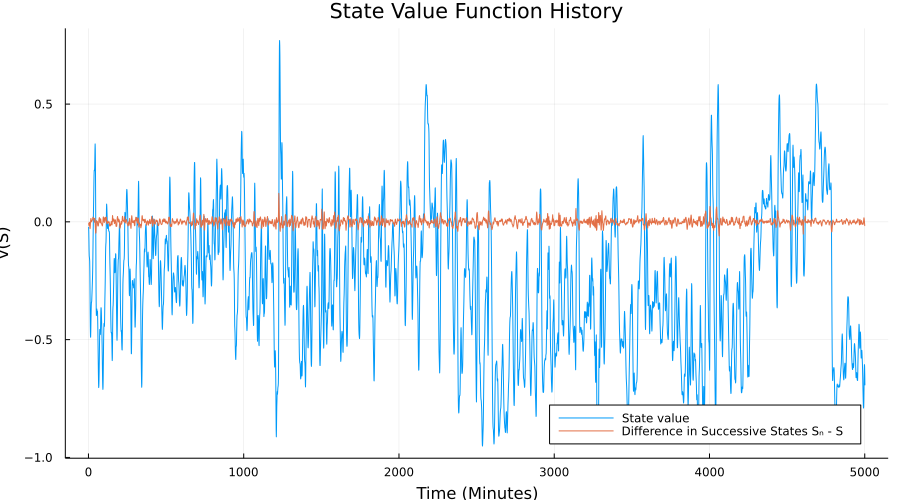

In [251]:
#
# Plot of the state value function and its successive differences through the timesteps of the dataset
#


plot(state_value_function_history[1,:],
    size=(900,500),title="State Value Function History",
    label="State value",xlabel="Time (Minutes)",ylabel="v(S)",
    legend=:bottomright)
plot!(state_value_function_history[2,:],label="Difference in Successive States Sₙ - S")

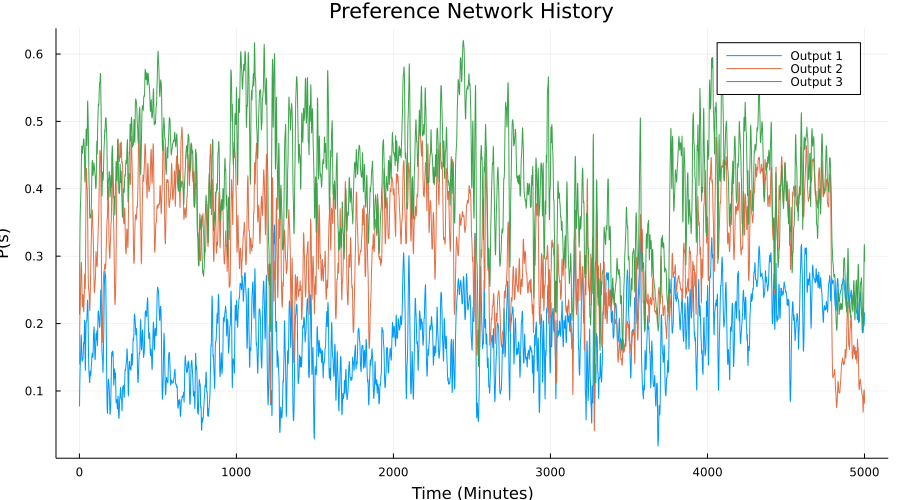

In [252]:
#
# Plot of the preference network's output (not action preferences) over the timesteps of the dataset
#

plot(preference_function_history[1,:],
    size=(900,500),title="Preference Network History",
    label="Output 1",xlabel="Time (Minutes)",ylabel="P(s)")
plot!(preference_function_history[2,:],label="Output 2")
plot!(preference_function_history[3,:],label="Output 3")

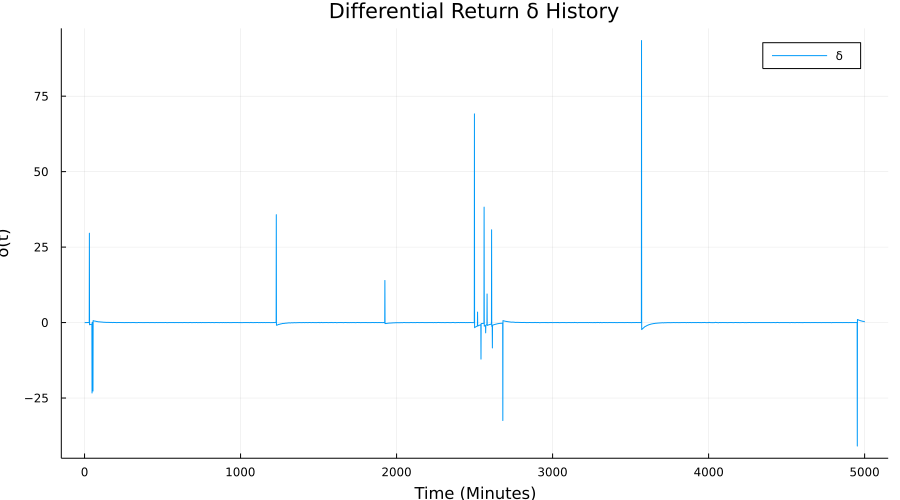

In [253]:
#
# Plot of the differential return through the timesteps of the dataset
#

plot(δ_history,size=(900,500),title="Differential Return δ History",xlabel="Time (Minutes)",ylabel="δ(t)",label="δ")

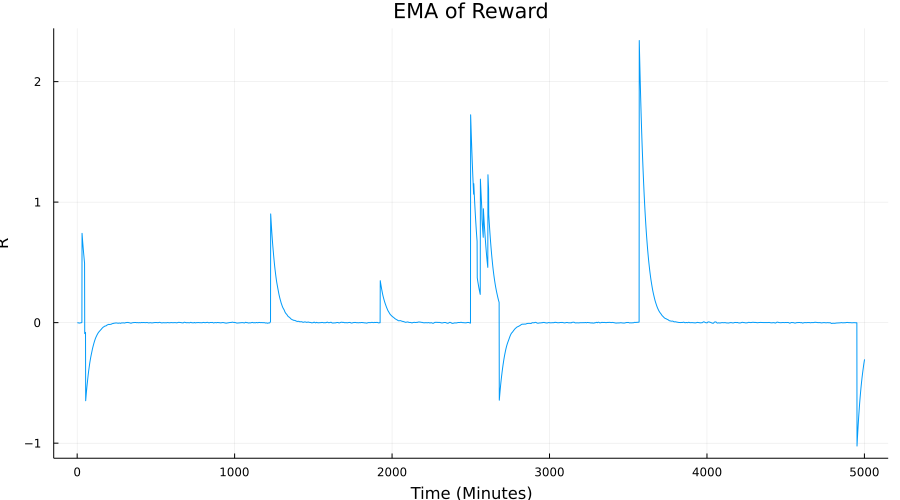

In [254]:
#
# Plot of the exponential moving average of rewards through the timesteps of the dataset
#

plot(R̂_history,size=(900,500),title="EMA of Reward",xlabel="Time (Minutes)",ylabel="R̂",legend=:false)

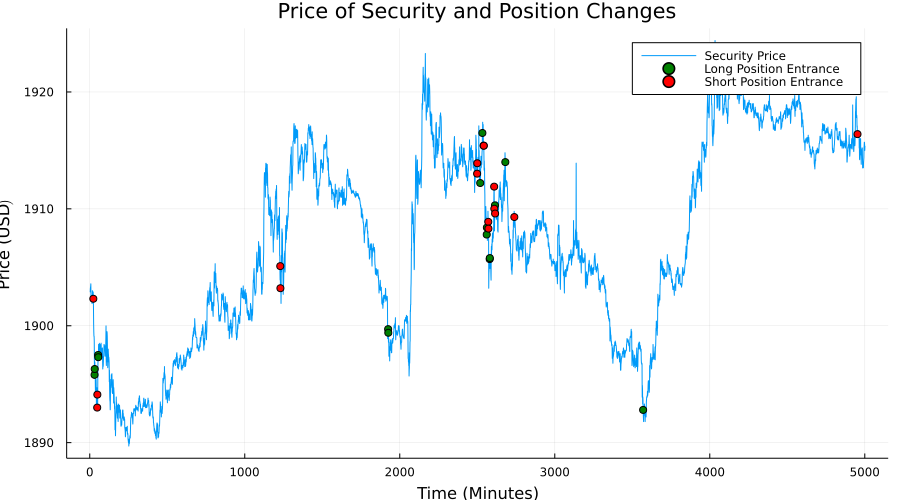

In [255]:
#
# Plot of the price chart over time from the dataset and points indicating the switching of position
# into longs and short with green and red dots respectively
#


plot(prices[_begin_:_end_],size=(900,500),legend=:topright,title="Price of Security and Position Changes",
    label="Security Price",xlabel="Time (Minutes)",ylabel="Price (USD\$)")

B_x = [c for c=1:length(prices[_begin_:_end_]) if position_change_history[c] === 1]
B = [prices[_begin_:_end_][c] for c=1:length(prices[_begin_:_end_]) if c in B_x]
Plots.scatter!(B_x,B,size=(900,500),color="Green",legend=:topright,label="Long Position Entrance")

S_x = [c for c=1:length(prices[_begin_:_end_]) if position_change_history[c] === 2]
S = [prices[_begin_:_end_][c] for c=1:length(prices[_begin_:_end_]) if c in S_x]
Plots.scatter!(S_x,S,size=(900,500),color="Red",legend=:topright,label="Short Position Entrance")


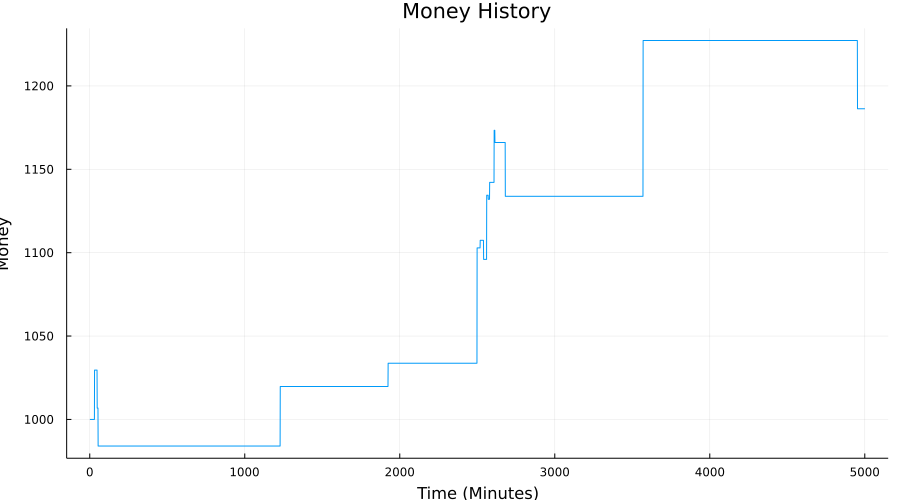

In [256]:
#
# Plot of the money balance through the timesteps of the dataset
#

plot(money_history,size=(900,500),title="Money History",xlabel="Time (Minutes)",ylabel="Money",legend=:false)

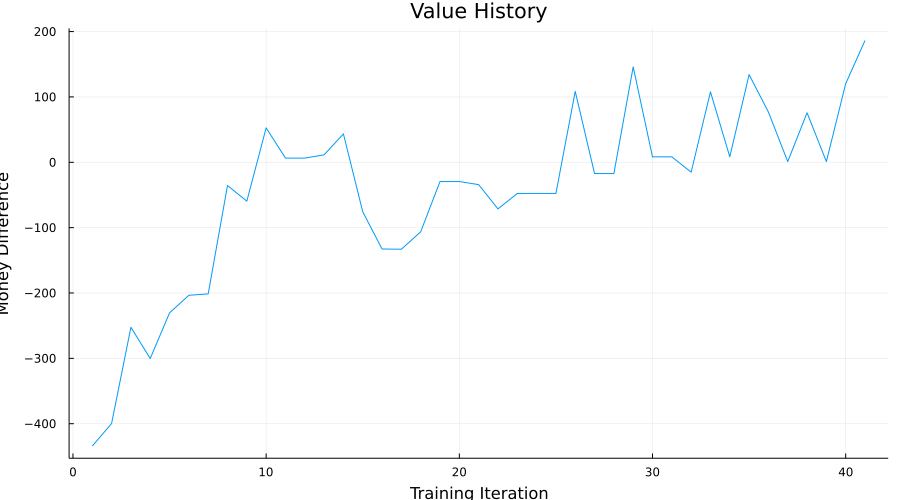

In [257]:
#
# Plot of the difference in money balance at the end of each training iteration 
#

plot(value_history,size=(900,500),title="Value History",xlabel="Training Iteration",ylabel="Money Difference",legend=:false)